## 淘宝用户行为数据分析  
### 项目介绍  

- 本数据集共有大约1200万条数据，数据为淘宝APP2014年11月18日至2014年12月18日的用户行为数据，共6列字段，列字段分别是：  
    - user_id：用户身份，脱敏  
    - item_id：商品ID，脱敏  
    - behavior_type：用户行为类型（包含点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示）  
    - user_geohash：地理位置  
    - item_category：品类ID（商品所属的品类）  
    - time：用户行为发生的时间

- 提出问题  
    - 不同时间维度下用户活跃度如何变化？  
    - 用户的留存情况如何（复购率及漏斗流失情况）？  
    - 用户价值情况？  


In [1]:
# 导入相关工具
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### 数据预处理

In [2]:
# 读取相应的数据
data = pd.read_csv('./tianchi_mobile_recommend_train_user.csv')

In [3]:
data.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


In [4]:
data.info() # 查看详细信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256906 entries, 0 to 12256905
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   item_id        int64 
 2   behavior_type  int64 
 3   user_geohash   object
 4   item_category  int64 
 5   time           object
dtypes: int64(4), object(2)
memory usage: 561.1+ MB


In [5]:
# 查看重复值数量
data.duplicated().sum()

4092866

In [6]:
# 删除重复值
data.drop_duplicates(inplace=True)

In [7]:
#查看缺失值
data.isnull().sum()

user_id                0
item_id                0
behavior_type          0
user_geohash     4308015
item_category          0
time                   0
dtype: int64

In [8]:
# 缺失值均为地理信息，对用户行为分析无影响，不做处理
data.drop('user_geohash',axis=1, inplace=True)

In [9]:
data.head()

,user_id,item_id,behavior_type,item_category,time
0,98047837,232431562,1,4245,2014-12-06 02
1,97726136,383583590,1,5894,2014-12-09 20
2,98607707,64749712,1,2883,2014-12-18 11
3,98662432,320593836,1,6562,2014-12-06 10
4,98145908,290208520,1,13926,2014-12-16 21


In [10]:
# 重置索引
data = data.reset_index(drop=True)

In [11]:
# 将time列拆分为date列和hour列,用做不同时间维度的分析
data['time'] = pd.to_datetime(data['time'])
data['date'] = data['time'].dt.date
data['date'] = pd.to_datetime(data['date'])
data['hour'] = data['time'].dt.hour
data.head()

,user_id,item_id,behavior_type,item_category,time,date,hour
0,98047837,232431562,1,4245,2014-12-06 02:00:00,2014-12-06,2
1,97726136,383583590,1,5894,2014-12-09 20:00:00,2014-12-09,20
2,98607707,64749712,1,2883,2014-12-18 11:00:00,2014-12-18,11
3,98662432,320593836,1,6562,2014-12-06 10:00:00,2014-12-06,10
4,98145908,290208520,1,13926,2014-12-16 21:00:00,2014-12-16,21


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164040 entries, 0 to 8164039
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        int64         
 1   item_id        int64         
 2   behavior_type  int64         
 3   item_category  int64         
 4   time           datetime64[ns]
 5   date           datetime64[ns]
 6   hour           int64         
dtypes: datetime64[ns](2), int64(5)
memory usage: 436.0 MB


In [13]:
#将item_id和item_category转换成str
data.item_id = data.item_id.astype(str)  #  ['item_id']
data.item_category = data.item_category.astype(str)

In [14]:
data['item_id'].dtype

dtype('O')

In [15]:
# 删除时间这一列 ,没有用了
data.drop(labels='time',axis=1,inplace=True)

### 用户行为分析

1. #### 时间维度的活跃度分析

In [16]:
data.head()

,user_id,item_id,behavior_type,item_category,date,hour
0,98047837,232431562,1,4245,2014-12-06,2
1,97726136,383583590,1,5894,2014-12-09,20
2,98607707,64749712,1,2883,2014-12-18,11
3,98662432,320593836,1,6562,2014-12-06,10
4,98145908,290208520,1,13926,2014-12-16,21


- 每天活跃度的变化  
    - 计算出日访问量，日独立访客量和人均访问量，封装成一个新的df

In [17]:
#日访问量  pv  page  views  
pv_daily_s = data.groupby(by='date')['user_id'].count()
pv_daily_s.head()

date
2014-11-18    235493
2014-11-19    233144
2014-11-20    226523
2014-11-21    213894
2014-11-22    232994
Name: user_id, dtype: int64

In [18]:
#日独立访客量 uv  unique  visitors  
uv_daily_s = data.groupby(by='date')['user_id'].nunique()
uv_daily_s.head()

date
2014-11-18    6343
2014-11-19    6420
2014-11-20    6333
2014-11-21    6276
2014-11-22    6187
Name: user_id, dtype: int64

In [19]:
#人均访问量（日访问量/日独立访客量）也可以叫做访问深度
uv_pv_s = pv_daily_s / uv_daily_s
uv_pv_s.head()

date
2014-11-18    37.126439
2014-11-19    36.315265
2014-11-20    35.768672
2014-11-21    34.081262
2014-11-22    37.658639
Name: user_id, dtype: float64

In [20]:
# 形成新的数据表
df = pd.concat((pv_daily_s,uv_daily_s,uv_pv_s),axis=1)
df.columns = ['pv','uv','pv/uv']
df.head()

,pv,uv,pv/uv
date,,,
2014-11-18,235493,6343,37.126439
2014-11-19,233144,6420,36.315265
2014-11-20,226523,6333,35.768672
2014-11-21,213894,6276,34.081262
2014-11-22,232994,6187,37.658639


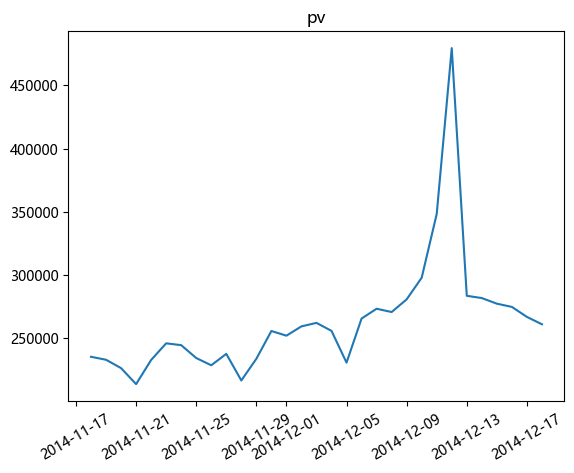

In [21]:
# 绘制PV折线图
plt.plot(df.index,df.pv)
plt.title('pv')
plt.xticks(rotation=30)
plt.show()

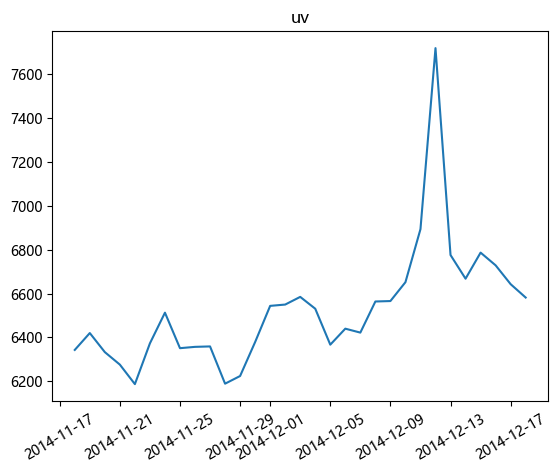

In [22]:
# 绘制UV者折线图
plt.plot(df.index,df.uv)
plt.title('uv')
plt.xticks(rotation=30)
plt.show()

- UV在一阶段升高, 但是PV降低 ,说明网站的弹出率升高了,需要对网站或者直接来了就走的那些人进行观察分析, 是什么原因导致弹出  
    - 1、用户没有看到想看的东西就走了。也就是说关键词和着陆页的相关性较低。  
    - 2、还是用户没有看到想看的东西。这个时候检查一下你的关键词是不是设置成广泛匹配了。  
    - 3、着陆页体验太差，用户可能在你的网站上看到了想要的东西。但是浏览选择很不顺畅  
    - 4、还是着陆页的问题。但这次不是说你的网站不好，而是你的网页打开速度太慢

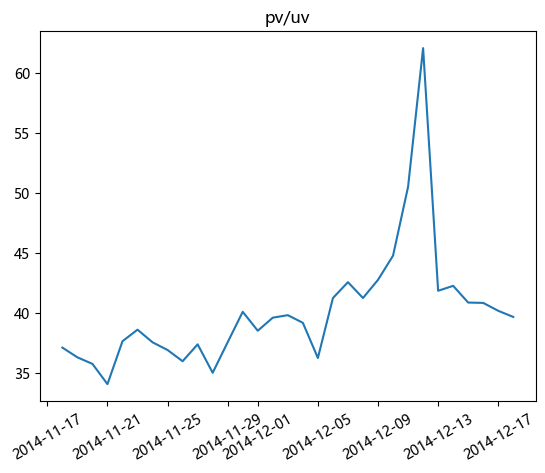

In [23]:
plt.plot(df.index,df['pv/uv'])
plt.title('pv/uv')
plt.xticks(rotation=30)
plt.show()

- 结论：在12月5日之前，活跃度在一定水平上波动。12月5日后，活跃度开始明显上升，并在双十二当天达到峰值。  
- 可能原因：12月5日之后双十二预热活动开始，用户活跃度上升。

- 双十二当天活跃度的变化  
    - 选择双十二当天的数据，分析其活跃时间段  
        - 双12当天每小时的访问量  
        - 双12当天每小时的访客量  
        - 双12当天每小时的人均访问量  
            - 形成一个新的df

In [24]:
#取出双12当天的数据
data_1212 = data.loc[data['date']=='2014-12-12']

In [25]:
#查看双12当天每小时的访问量
pv_hour_s = data_1212.groupby(by='hour')['user_id'].count()
#查看双12当天每小时的访客量
uv_hour_s = data_1212.groupby(by='hour')['user_id'].nunique()
#查看双12当天每小时的人均访问量
pv_uv_s = pv_hour_s / uv_hour_s

In [26]:
df = pd.concat((pv_hour_s,uv_hour_s,pv_uv_s),axis=1)
df.columns = ['pv_hour','uv_hour','pv/uv']
df.head()

,pv_hour,uv_hour,pv/uv
hour,,,
0,25075,1569,15.981517
1,11388,811,14.041924
2,5956,411,14.491484
3,3177,255,12.458824
4,2567,211,12.165877


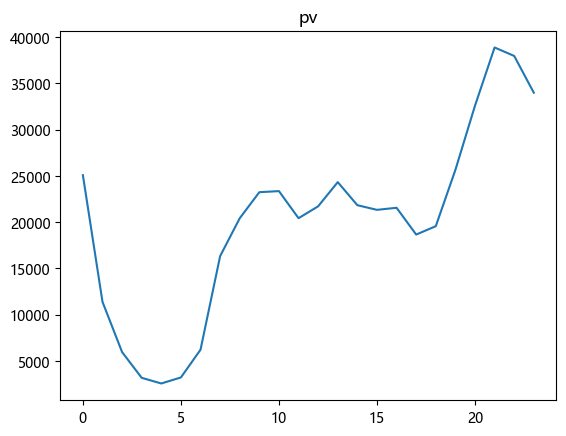

In [27]:
plt.plot(df.index,df.pv_hour)
plt.title('pv')
plt.show()

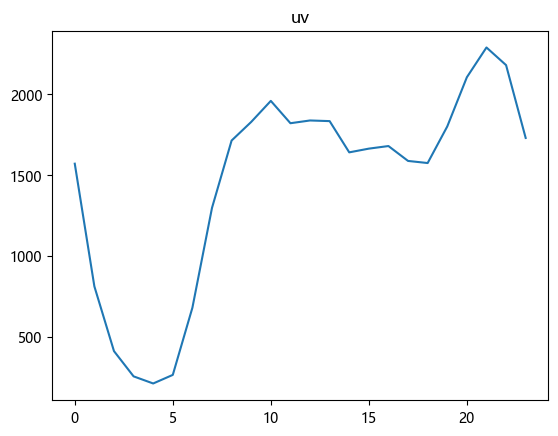

In [28]:
plt.plot(df.index,df.uv_hour)
plt.title('uv')
plt.show()

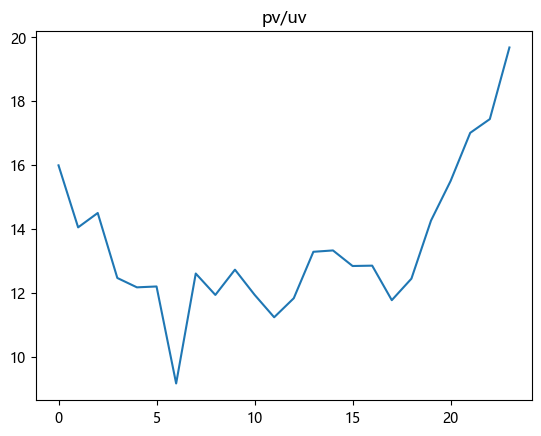

In [29]:
plt.plot(df.index,df['pv/uv'])
plt.title('pv/uv')
plt.show()

- 结论：双十二当天0点和18点之后淘宝用户活跃度较高，6点跌至最低点。  
- 建议：商家可以在18点后设置优惠券或采取其他促销手段，吸引更多人消费，提高购买率。

#### 2、用户行为活跃度变化  
- 查看每天不同行为的各自的总量  

![Image Name](https://cdn.kesci.com/upload/image/rds1rymiun.jpg?imageView2/0/w/320/h/320)  

- 提示：源数据中的一行数据表示一个用户的某一个行为的数据  
- 注意：aggfunc的count和size的区别

In [30]:
data.head()

,user_id,item_id,behavior_type,item_category,date,hour
0,98047837,232431562,1,4245,2014-12-06,2
1,97726136,383583590,1,5894,2014-12-09,20
2,98607707,64749712,1,2883,2014-12-18,11
3,98662432,320593836,1,6562,2014-12-06,10
4,98145908,290208520,1,13926,2014-12-16,21


In [31]:
data.pivot_table(index='date',aggfunc='count').head(2)

,behavior_type,hour,item_category,item_id,user_id
date,,,,,
2014-11-18,235493,235493,235493,235493,235493
2014-11-19,233144,233144,233144,233144,233144


In [32]:
data.pivot_table(index='date',aggfunc='size').head(2)

date
2014-11-18    235493
2014-11-19    233144
dtype: int64

In [33]:
#count返回比size更加冗长的数据，因此使用size即可
pv_df = data.pivot_table(index='date',columns='behavior_type',aggfunc='size',fill_value=0)
pv_df.head()

behavior_type,1,2,3,4
date,,,,
2014-11-18,215480,6797,9800,3416
2014-11-19,213108,7079,9607,3350
2014-11-20,206740,7063,9552,3168
2014-11-21,196121,6722,8328,2723
2014-11-22,213292,7001,9493,3208


- 将四种行为的总量绘制在一个坐标系中查看

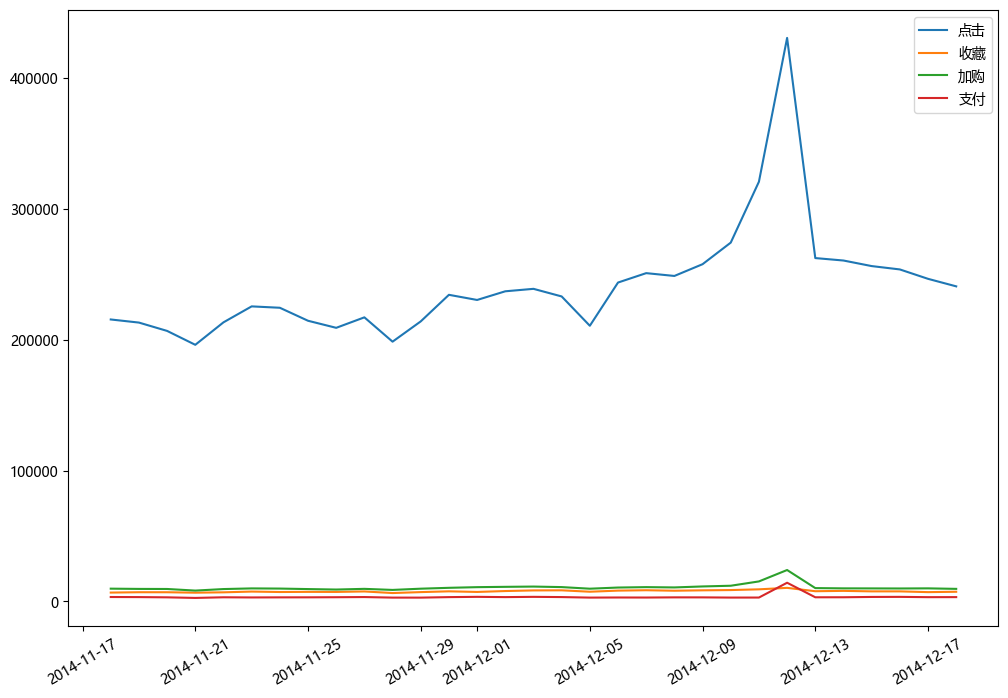

In [34]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=30)
plt.plot(pv_df.index,pv_df[1],label='点击')
plt.plot(pv_df.index,pv_df[2],label="收藏")
plt.plot(pv_df.index,pv_df[3],label='加购')
plt.plot(pv_df.index,pv_df[4],label='支付')
plt.legend()
plt.show()

- 结论：  
    - 点击、收藏、加购物车、支付这四种行为均在双十二当天达到顶峰。  
    - 只观察支付和收藏，发现双十二当天支付量大于收藏量。  
        - 支付量大于收藏量说明很多用户购买了目标之外的商品，可能是受到促销的影响冲动消费，又或者是为了凑单等。  


#### 3、留存率分析

- 漏斗转化情况  
    - 查看不同行为的总量，封装到df中  

    - 单一环节转化率(%)-各环节转换率作为新的列存在  
        - 计算点击到收藏、收藏到加购，加购到支付的转化率  
    - 整体转化率(%)-作为新的一列存在  
        - 计算点击到收藏、加购和支付的整体转化率  
    - 每一环节流失率(%)  
        - 100-单一环节转化率

In [35]:
s = data['behavior_type'].value_counts()
s

1    7479078
3     333371
2     240919
4     110672
Name: behavior_type, dtype: int64

In [36]:
#查看不同行为的访问量，封装到df中
s = data['behavior_type'].value_counts()
s.index = ['点击','加购物车','收藏','支付']
df = pd.DataFrame([s.index,s])
df

,0,1,2,3
0,点击,加购物车,收藏,支付
1,7479078,333371,240919,110672


In [37]:
#查看不同行为的访问量，封装到df中
s = data['behavior_type'].value_counts()
s.index = ['点击','加购物车','收藏','支付']
df = pd.DataFrame([s.index,s]).T
df.columns = ['用户行为','访问量']
df

,用户行为,访问量
0,点击,7479078
1,加购物车,333371
2,收藏,240919
3,支付,110672


In [38]:
#计算点击到收藏、收藏到加购，加购到支付的转化率
temp1 = df['访问量'][1:].values
temp2 = df['访问量'][0:-1].values
p = temp1 / temp2 * 100
p = list(p)
p.insert(0,100)
p

[100, 4.457380976639099, 72.26753376868413, 45.937431252827714]

In [39]:
temp1

array([333371, 240919, 110672], dtype=object)

In [40]:
temp2

array([7479078, 333371, 240919], dtype=object)

In [41]:
df['单一环节转化率(%)'] = p
df

,用户行为,访问量,单一环节转化率(%)
0,点击,7479078,100.000000
1,加购物车,333371,4.457381
2,收藏,240919,72.267534
3,支付,110672,45.937431


In [42]:
#计算整体转化率
df['整体转化率(%)'] = df['访问量'] / df.iloc[0,1] * 100
df

,用户行为,访问量,单一环节转化率(%),整体转化率(%)
0,点击,7479078,100.000000,100.0
1,加购物车,333371,4.457381,4.457381
2,收藏,240919,72.267534,3.221239
3,支付,110672,45.937431,1.479755


In [43]:
#计算每一环节流失率(%)
df['每一环节流失率(%)'] = 100 - df['单一环节转化率(%)']
df

,用户行为,访问量,单一环节转化率(%),整体转化率(%),每一环节流失率(%)
0,点击,7479078,100.000000,100.0,0.000000
1,加购物车,333371,4.457381,4.457381,95.542619
2,收藏,240919,72.267534,3.221239,27.732466
3,支付,110672,45.937431,1.479755,54.062569


In [44]:
#整体转化率的漏斗转化图
from pyecharts.charts import Funnel
from pyecharts import options as opts
funnel = Funnel().add(
                series_name = '整体转化率(%)',
                data_pair = [ list(z) for z in zip(df['用户行为'],df['整体转化率(%)']) ],
                is_selected = True,
                label_opts = opts.LabelOpts(position = 'inside')
                )
funnel.set_series_opts(tooltip_opts = opts.TooltipOpts(formatter = '{a}<br/>{b}:{c}%'))
funnel.set_global_opts(title_opts = opts.TitleOpts(title = '整体转化率(%)') )
funnel.render_notebook()

- 结论：用户的流失主要发生在点击-收藏环节。

- 可能原因及建议  
    - 点击-收藏环节流失  
        - 原因：用户被投放的广告吸引，进入后发现与预期严重不合，造成流失。  
        - 建议：优化广告。  
        - 原因：客户通过检索或推荐到列表页面但没找到合适的产品，造成流失。  
        - 建议：更新搜索引擎和相关算法，尽可能精准推送相关内容。  
        - 原因：如果商品的评价过低，造成流失。  
        - 建议：商家要做进一步调查，分析用户对商品评价低的原因，进一步改进，提升用户的购物体验，最终可以口碑营销。  
    - 收藏-加购物车环节流失  
        - 此类用户有较强的购买需求。可以对用户进行精准推送促销信息，刺激用户完成购买。  
    - 加购物车-支付环节流失  
        - 原因：生成订单页面步骤过多。  
        - 建议:  
            - 优化购物流程，尽可能支持多种支付方式，如银行卡、微信支付、支付宝支付、花呗等。  
            - 考虑目前到淘宝的购物流程已经很难再简化，需要商家进一步调查，了解用户放弃支付的原因，方便做出调整。

#### 4、复购情况分析  
- 用户购买次数直方图  
- 计算复购率=购买次数大于1的用户数量/有购买行为的用户总数

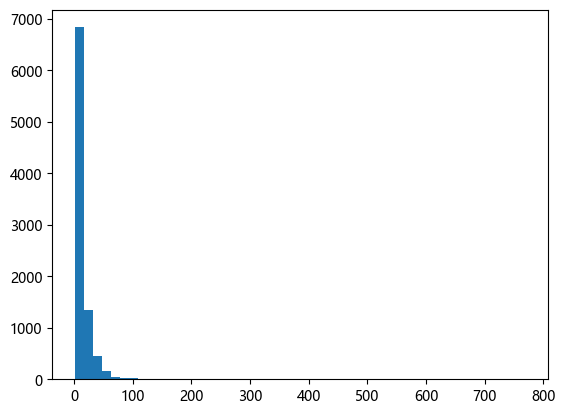

user_id
4913          6
6118          1
7528          6
7591         21
12645         8
             ..
142376113     1
142412247    11
142430177     5
142450275    39
142455899     8
Name: behavior_type, Length: 8886, dtype: int64

In [45]:
#用户购买次数直方图
buy_df = data.loc[data['behavior_type'] == 4]
user_buy_s = buy_df.groupby(by='user_id')['behavior_type'].count()
plt.hist(user_buy_s,bins=50)
plt.show()
user_buy_s

In [46]:
#计算复购率=购买次数大于1的用户数量/有购买行为的用户总数
reBuy_rate = user_buy_s[user_buy_s > 1].count() / user_buy_s.count() * 100
reBuy_rate

91.44722034661264

- 结论：2014年11月18日至2014年12月18日这一个月用户复购率高达91.45%

### 用户价值分析（RMF模型）  
- 对已购用户进行价值划分  
- 各类用户占比

In [47]:
#将已购用户的数据单独取出
buy_df = data.loc[data['behavior_type'] == 4]
buy_df.head()

,user_id,item_id,behavior_type,item_category,date,hour
143,101260672,73008997,4,4076,2014-11-25,13
146,116730636,85319721,4,10079,2014-12-17,11
152,104811265,61764614,4,675,2014-12-01,13
177,106230218,238910858,4,12090,2014-12-03,11
198,100684618,271840783,4,12220,2014-11-23,18


In [48]:
buy_df['date'].max()

Timestamp('2014-12-18 00:00:00')

In [49]:
list(buy_df.groupby(by='user_id')['date'])[3]

(7591,
 625981    2014-12-06
 626385    2014-11-25
 626392    2014-12-02
 626532    2014-12-04
 1605162   2014-12-10
 1605542   2014-12-12
 2979569   2014-12-12
 4473350   2014-12-04
 4473479   2014-12-03
 5438459   2014-12-10
 5438669   2014-12-12
 5752184   2014-12-12
 5752429   2014-12-13
 6839354   2014-12-13
 6839637   2014-12-10
 7140622   2014-12-11
 7140676   2014-12-10
 7140785   2014-12-06
 7770509   2014-12-11
 7770801   2014-12-04
 7770812   2014-12-11
 Name: date, dtype: datetime64[ns])

In [52]:
#计算R：R表示客户最近一次交易时间的间隔
#/np.timedelta64(1,'D')去出days
now_date = buy_df['date'].max()
R = buy_df.groupby(by='user_id')['date'].apply(lambda x:now_date - x.max()) / np.timedelta64(1,'D')

In [53]:
R.head()

user_id
4913     2.0
6118     1.0
7528     5.0
7591     5.0
12645    4.0
Name: date, dtype: float64

In [54]:
#计算F：每个用户消费频率
F = buy_df.groupby(by='user_id')['date'].count()

In [55]:
F.head()

user_id
4913      6
6118      1
7528      6
7591     21
12645     8
Name: date, dtype: int64

In [56]:
pd.DataFrame(data=[R,F],index=['R','F'])

user_id,4913,6118,7528,7591,12645,54056,63348,79824,88930,100539,...,142306250,142306361,142337230,142358910,142368840,142376113,142412247,142430177,142450275,142455899
R,2.0,1.0,5.0,5.0,4.0,11.0,7.0,2.0,1.0,2.0,...,5.0,0.0,5.0,4.0,2.0,10.0,3.0,0.0,5.0,14.0
F,6.0,1.0,6.0,21.0,8.0,2.0,1.0,13.0,23.0,18.0,...,10.0,7.0,4.0,2.0,11.0,1.0,11.0,5.0,39.0,8.0


In [57]:
# 交易金额缺失，只考虑最后交易日期和交易频率两个维度

In [58]:
rfm = pd.DataFrame(data=[R,F],index=['R','F']).T
rfm.head()

,R,F
user_id,,
4913,2.0,6.0
6118,1.0,1.0
7528,5.0,6.0
7591,5.0,21.0
12645,4.0,8.0


In [59]:
#将各维度分成两个程度
recent_avg = rfm['R'].mean()
freq_avg = rfm['F'].mean()
#  R应该是越小越好，则R小于均值返回1，否则返回0
def rec_value(x):
    if x < recent_avg:  #  R avg  
        return '1'
    else:
        return '0'
# F应该是越大越好，则F大于均值返回1，否则返回0   
def freq_value(x):
    if x > freq_avg:
        return '1'
    else:
        return '0'
rfm['R_value'] = rfm['R'].apply(rec_value)
rfm['F_value'] = rfm['F'].apply(freq_value)



In [60]:
#将R和F拼接到一起
rfm['rfm']=rfm['R_value'].str.cat(rfm['F_value'])


In [61]:
rfm['rfm'].head()

user_id
4913     10
6118     10
7528     10
7591     11
12645    10
Name: rfm, dtype: object

In [62]:
#根据R和F的拼接判定用户等级
def rfm_value(x):
    if x == '10':  #购买间隔短，但是购买频率低
        return '重要发展客户'
    elif x == '01':#购买间隔长，但是购买频率高
        return '重要保持客户'
    elif x == '00':
        return '重要挽留客户'
    else:
        return '重要价值客户'
rfm['user_type'] = rfm['rfm'].apply(rfm_value)
rfm.head()

,R,F,R_value,F_value,rfm,user_type
user_id,,,,,,
4913,2.0,6.0,1,0,10,重要发展客户
6118,1.0,1.0,1,0,10,重要发展客户
7528,5.0,6.0,1,0,10,重要发展客户
7591,5.0,21.0,1,1,11,重要价值客户
12645,4.0,8.0,1,0,10,重要发展客户


In [63]:
#各类用户占比
user_type_count_s = rfm['user_type'].value_counts()
user_type_count_s / user_type_count_s.sum() * 100

重要挽留客户    34.233626
重要发展客户    33.400855
重要价值客户    27.143822
重要保持客户     5.221697
Name: user_type, dtype: float64

- 结论  
    - 重要挽留客户：占比最大，该类用户消费时间间隔较远，并且消费频次低。需要主动联系客户，调查清楚哪里出现了问题，可以通过短信，邮件，APP推送等唤醒客户，尽可能减少流失。  
    - 重要发展客户：消费频次低，可以适当给点折扣或捆绑销售来增加用户的购买频率，尽可能提高留存率。  
    - 重要价值客户：为重点用户，但用户比较少。可以针对性地给这类客户提供 VIP服务；  
    - 重要保持客户：消费时间间隔较远，但是消费频次高。该类用户可能一次性购买很多东西。对于这类客户，需要主动联系，关注他们的购物习性做精准化营销，及时满足这类用户的需求。  
